In [20]:
from Utils import normalize_meshId,preprocess_text
from pandas import read_csv
from Data_retrieval import load_dataset
from Evalutation import graphType, model_evaluation, create_knowledge_graph, plot_hist,find_matches_drug_disease, pValues_DDAs
from collections import Counter
from numpy import array

from itertools import product
from tqdm.notebook import tqdm
tqdm.pandas()

%reload_ext autoreload
%autoreload 2

In [21]:
df_texts, df_entities = load_dataset()

df_entities = df_entities[~df_entities['prob'].isna()]
df_entities = df_entities[df_entities['prob'] > 0.8]
df_entities = df_entities[['id', 'pmid', 'mention', 'obj', 'span_begin', 'span_end']]

## Test set creation

To test the knowledge graph is used the SCMFDD dataset, there are three kinds of files: diseases, drugs and diseases-drugs associations.

The dataframe `diseases-drug` associations contains:
- drug_id: id of drug
- drug_name: plain name of drug
- disease_id: id of disease
- disease_name: plain name of disease

In [22]:
SCMFF_DIR = 'dataset/SCMFDD/SCMFDD-L/'

scmff_dda = read_csv(f'{SCMFF_DIR}drug-disease association.csv')
scmff_drugs = read_csv(f'{SCMFF_DIR}drug.csv')
scmff_diseases = read_csv(f'{SCMFF_DIR}disease.csv')

Add column `source` that is `true` for each disease of `df_entities` that is also inside the test set.

In [29]:
scmff_diseases_labels = scmff_diseases['disease_id'].unique()
union_diseases = list(filter(lambda x: normalize_meshId(x) in scmff_diseases_labels,
                             df_entities[df_entities['obj'] == 'disease']['id'].unique()))

df_entities['source'] = (df_entities['obj'] == 'disease') & (df_entities['id'].isin(union_diseases))

sum(df_entities['source'])

64555

In [30]:
scmff_dda['drug_id'] = scmff_dda['drug_id'].apply(normalize_meshId)
scmff_dda['disease_id'] = scmff_dda['disease_id'].apply(normalize_meshId)

normalized_union_diseases = map(normalize_meshId, union_diseases)
scmff_dda = scmff_dda[scmff_dda['disease_id'].isin(normalized_union_diseases)]

In [31]:
test_set = {
    (
        v['drug_id'],
        v['disease_id']
    ): True for v in scmff_dda[['drug_id', 'disease_id']].to_dict(orient='records')
}

In [32]:
scmff_dda

,drug_id,drug_name,disease_id,disease_name
1,C074619,bivalirudin,D006470,Hemorrhage
2,C074619,bivalirudin,D007249,Inflammation
3,C074619,bivalirudin,D007511,Ischemia
4,C074619,bivalirudin,D013921,Thrombocytopenia
5,C074619,bivalirudin,D013927,Thrombosis
...,...,...,...,...
49212,D013747,Tetrabenazine,D017109,"Akathisia, Drug-Induced"
49213,D013747,Tetrabenazine,D018476,Hypokinesia
49214,D013747,Tetrabenazine,D020734,Parkinsonian Disorders
49215,D013747,Tetrabenazine,D020820,Dyskinesias


# Model evalutation

In [ ]:
id_to_wuid = {id: f'unique_{i}' for i, id in enumerate(df_entities['id'].unique())}
texts = df_texts.progress_apply(preprocess_text(df_entities,id_to_wuid), axis=1).tolist()

Configuration to try

In [8]:
coc_configs = dict(
    k=list(range(5, 41, 5))
)

w2v_configs = dict(
    learning_rate=[0.1],    # Learning rate to training the model
    epochs=[100],           # Number of epochs
    vector_size=[100, 500], # Latent space dimension
    sg=[False, True],       # False->CBOW (Continuous bag of words) True->skip-gram
    window=[5, 10],         # contex window dimension
    min_count=[2, 5],       # threshold for the frequency
)

configs = [
    *[(graphType.COOCCURRENCES, dict(zip(coc_configs, t))) for t in product(*coc_configs.values())],
    *[(graphType.WORD2VEC, dict(zip(w2v_configs, t))) for t in product(*w2v_configs.values())],
]

Automatically try all configurations and rank them by precision achieved

In [ ]:
ranking = model_evaluation(configs=configs,
                     ts_set=test_set,
                     texts=texts,
                     df_entities=df_entities,
                     max_diseases=100,
                     top_z=10)

In [ ]:
for precision, config in ranking:
    print(precision, config)

### We found that the best configuration is with Cooncurrences with k = 10

In [9]:
configs[1][1]

{'k': 10}

In [10]:
# precision, config = ranking[1]
graph = create_knowledge_graph(configs[1], df_entities, test_set)

Co_occurrencesGraph populate_adj_matrix: 100%|██████████| 9898/9898 [01:40<00:00, 98.04it/s] 


## Evaluation A

In [11]:
matches = find_matches_drug_disease(graph, top_z=10, test_set=test_set, max_diseases=100)

test_drug_disease: 100%|██████████| 100/100 [03:44<00:00,  2.25s/it]


Describe the precision achieved for 100 diseases

Counter({0.0: 71, 0.1: 27, 0.2: 1, 0.4: 1, 0.3: 0})


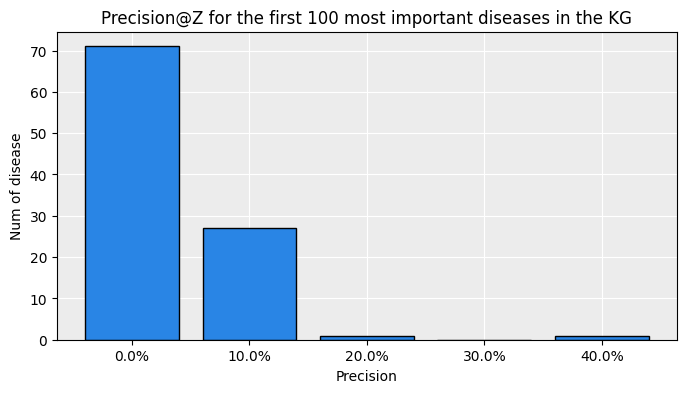

In [16]:
from Evalutation import plot_hist
%reload_ext autoreload
%autoreload 2
t = Counter(matches)
t[.3] = 0
print(t)
t = dict(sorted(t.items(), key=lambda item: item[0]))
x = array(list(t.keys())) * 10
y = array(list(t.values()))

plot_hist(x,y)

## Evaluation B

In [15]:
# create a dictionary of DDA from test_set
disease_drugs = {}
for (drug, disease), _ in test_set.items():
    if disease not in disease_drugs:
        disease_drugs[disease] = [drug]
    else:
        disease_drugs[disease].append(drug)

In [ ]:
pValues = pValues_DDAs(graph=graph,
                       ddas=disease_drugs,
                       max_diseases=10,
                       n_samples=3)

In [36]:
pValues = [0.4474150974725506,
 0.7758916519397002,
 0.42578987277497826,
 0.6834724817423341,
 0.44755628041210505,
 0.2856933831503558,
 0.00020957884158454972,
 0,
 0,
 0.024716017356946285,
 0.1359102710650009,
 0.8359753942553461,
 0.4708784117318766,
 0.15633057892315078,
 0.0417535284967034,
 0.2770658573997668,
 0.7696008559247212,
 0.47669944424089467,
 0,
 0.213685989598322]

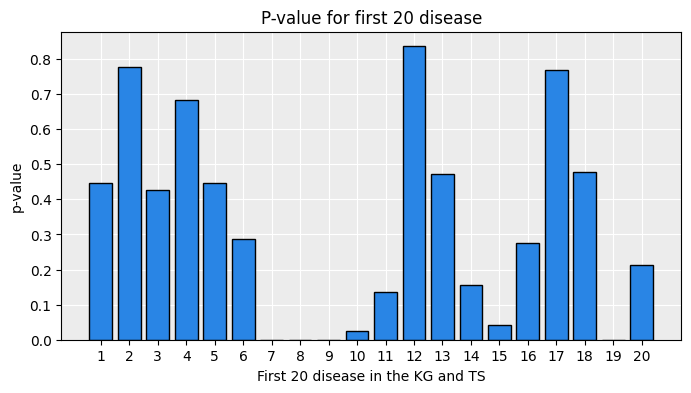

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
ax = plt.axes()
ax.set_facecolor("#ececec")
ax.set_axisbelow(True)
ax.yaxis.grid(color='white')
ax.xaxis.grid(color='white')
plt.bar(range(len(pValues)), pValues, color="#2985e5", edgecolor="black")
plt.xticks(range(len(pValues)), [*range(1,len(pValues)+1)])
plt.xlabel("First 20 disease in the KG and TS")
plt.ylabel("p-value")
plt.title("P-value for first 20 disease")
plt.show()